In [1]:
!pip install numpy==1.25.2
!pip install networkx==3.1
!pip install scipy==1.11.1

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [2]:
import numpy as np

import math

import copy
import random

import pickle

import datetime

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.integrate as integrate


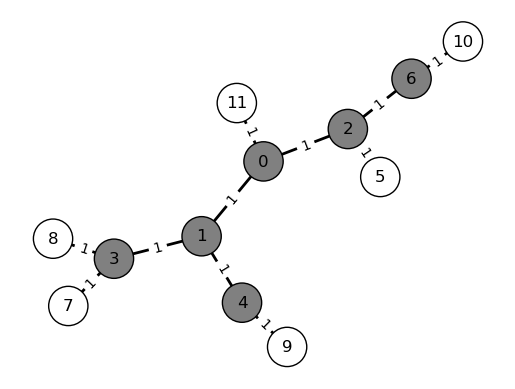

In [3]:
# An example of the rumor graph, where infected nodes are in grey.

# seed is used in "nx.spring_layout(G, seed=pos_SEED)"
pos_SEED=0

G = nx.Graph()

G.add_nodes_from(range(11))

G.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9),(6,10),(0,11)])

for e in G.edges(data=True):
    G[e[0]][e[1]]["weight"]=1

edge_labels = nx.get_edge_attributes(G,'weight')
    
nodes_infected={0,1,2,3,4,6}

# Set the colors for infected nodes and uninfected nodes in the graph
node_colors = ['gray' if i in nodes_infected else 'white' for i in range(G.number_of_nodes())]

# Draw the graph
pos = nx.spring_layout(G, seed=pos_SEED)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors= 'black')
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(G.number_of_nodes())}, font_size=12)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off')
plt.show()

In [4]:
"""
Construct the parent and child relation between nodes after selecting a node as source.
"""
# source=0
# source = list(nodes_infected)[0]
def parent_child_relation(G, nodes_infected, source):
    parent={} # 'key:value' pair where 'value' is the parent node for node 'key'
    child={} #'key:value' pair where 'value' is the set of child nodes for node 'key'
    depth={} # 
    nodes_waiting_child=set() # nodes haven't assigned child
    b_uninfected=set() #susceptible nodes at final observation; uninfected nodes which have infected neighbors
    b_infected=set() #infected nodes which have uninfected neighbors
    leaf_infected=set() # the leaf infected nodes

    leaf_uninfected=set() # the uninfected nodes whoes parent is in leaf_infected
    pseudo_leaf_uninfected=set() # the uninfected nodes whoes parent is infected but not in leaf_infected

    parent[source]=None
    depth[source]=0
    nodes_waiting_child.add(source)
    while len(nodes_waiting_child)!=0:
        i=nodes_waiting_child.pop()
        child[i]= set(j for j in G.neighbors(i) if j not in parent.keys())
        if i!=source:
            i_is_leaf_infected = True 
        else:
            i_is_leaf_infected = False
        i_has_infected_child = False
        i_uninfected_child=set()
        for j in child[i]:
            parent[j]=i
            if j in nodes_infected:
                depth[j]=depth[i]+1
                nodes_waiting_child.add(j)
                i_is_leaf_infected = False
                i_has_infected_child = True
            else:
                b_uninfected.add(j)
                i_uninfected_child.add(j)
        if i_has_infected_child==True:
            b_infected.add(i)
        if i_is_leaf_infected==True:
            leaf_infected.add(i)
            leaf_uninfected = leaf_uninfected.union(i_uninfected_child)
        # print(i, child[i])
        
    #### pay attention to the uninfected neighbors of the source.
    root_uninfected_child = child[source].intersection(b_uninfected)
    pseudo_leaf_uninfected = b_uninfected - leaf_uninfected -root_uninfected_child 
    return parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected


# parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected = parent_child_relation(G=G.subgraph([0]), nodes_infected=nodes_infected, source=source)
    
# print(parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected,sep="\n")

In [5]:
def extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible):
    ## gr_main is the subgraph of infected and susceptible nodes, with edges between susceptible nodes removed
    gr_main=gnp.subgraph(list(gr_nodes_infected) + list(gr_nodes_susceptible)).copy()
    # remove the edges between susceptible nodes
    for u in gr_nodes_susceptible:
        for v in set(gr_main.neighbors(u)).intersection(gr_nodes_susceptible):
            gr_main.remove_edge(u,v)
    return gr_main

def extract_bfs(gr_main, gr_nodes_infected, gr_nodes_susceptible, s_selected):
    gr_bfs=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), s_selected).to_undirected()
    for i in gr_nodes_susceptible:
        if gr_main.degree[i]==1:
            gr_bfs.add_edges_from(gr_main.edges(i))
        else:
            v_cand=sorted([v for (_,v) in gr_main.edges(i)],reverse=True)
            # print(gr_main.edges(i),v_cand)
            v_dist_min=np.inf
            v_arg_min=v_cand[0]  # the infected neighbors of i that will be selected by bfs w.r.t s_selected
            for v in v_cand:
                v_dist=nx.shortest_path_length(gr_bfs, s_selected, v)
                if v_dist<=v_dist_min:
                    v_arg_min=v
                    v_dist_min=v_dist
            gr_bfs.add_edge(i, v_arg_min)
    return gr_bfs

In [6]:
def fhat(t,k,d,T2):
    return (t**(k-1)*np.exp(-t)/math.factorial(k-1))*np.exp(-(T2-t)*(d-1))

def fhat_integral(T1, T2, k, d):
    # print("T1, T2, k, d",T1, T2, k, d)
    return integrate.quad(fhat, T1, T2, args=(k,d,T2))

In [7]:

# tmax=4
# gr_main=G 
# gr_nodes_infected=nodes_infected
# gr_nodes_susceptible=b_uninfected


def compute_likelihood(tmax, gr_main, gr_nodes_infected, gr_nodes_susceptible, tcount=21, dynamic_scale=False):
    '''return the likelihood for each node to be the source;
    tmax: the maximum time to maximize over;
    The return is a list, the i-th element is a dict storing node-likelihood for i-th critical time 
    '''

    t_list = np.linspace(0, tmax, tcount)
    t_positions=[i for i in range(len(t_list))]

    
    result=[{} for i in t_positions]
    scale_num=[{} for i in t_positions]
    for source in gr_nodes_infected:
        message=[{} for i in t_positions]
        
        G=extract_bfs(gr_main, gr_nodes_infected, gr_nodes_susceptible, s_selected=source)
        
        parent,child,b_uninfected,b_infected,depth,leaf_infected, root_uninfected_child, pseudo_leaf_uninfected = parent_child_relation(G=G, nodes_infected=gr_nodes_infected, source=source)

        for t_pos in t_positions:
            for i in leaf_infected:
                if depth[i]==0:
                    print(gr_nodes_infected, gr_nodes_susceptible, gr_main.edges(),'\n', 'i', i, 't_list[t_pos], depth[i], G.degree[i]', t_list[t_pos], depth[i], G.degree[i])
                message[t_pos][i]=fhat_integral(0, t_list[t_pos], depth[i], G.degree[i])[0]
                
            for i in pseudo_leaf_uninfected:
                message[t_pos][i]=fhat_integral(0, t_list[t_pos], depth[parent[i]], 2)[0]

            for i in root_uninfected_child:
                message[t_pos][i]=math.exp(-t_list[t_pos])
            
            if dynamic_scale==True:
                scale_num[t_pos][source]=0
                result[t_pos][source]=1
                for m in message[t_pos].values():
                    if result[t_pos][source]<10**(-6):
                        result[t_pos][source]=result[t_pos][source]*10**20
                        scale_num[t_pos][source]+=1
                    result[t_pos][source]=result[t_pos][source]*m
            else:
                result[t_pos][source]=np.prod(list(message[t_pos].values()))
                # result[t_pos][source]=np.prod([10**300]+list(message[t_pos].values()))

                
            
            ## to save memory
            # print(max(message[t_pos].values()))
            message[t_pos]={}
            
    if dynamic_scale==True:
        scale_num_min=min([min(scale_num[t_pos].values()) for t_pos in t_positions])
        for t_pos in t_positions:
            for k,v in result[t_pos].items():
                result[t_pos][k]=v*10**(-20*(scale_num[t_pos][k]-scale_num_min))
        # print(scale_num)
        
            
    return result, t_positions

# result, t_positions = compute_likelihood(tmax=tmax, gr_main=G, 
#                                          gr_nodes_infected=gr_nodes_infected,gr_nodes_susceptible=gr_nodes_susceptible)
# # result, t_positions = compute_likelihood(tmax=tmax, gr_main=G, gr_nodes_infected=gr_nodes_infected,gr_nodes_susceptible=gr_nodes_susceptible,dynamic_scale=True)


# print(result)
    

In [8]:
def extract_max_nodes(result, nodes_infected):
    result_by_node={}
    for i in nodes_infected:
        result_by_node[i]=[]
        for t_pos in t_positions:
            result_by_node[i].append(result[t_pos][i])
            
    max_nodes_t_pos={}
    max_value=0
    max_nodes=set()

    for k,v in result_by_node.items():
        max_index=np.argmax(v)
        max_nodes_t_pos[k]=max_index
        if np.isclose(v[max_index],max_value):
            max_nodes.add(k)
        elif v[max_index]>max_value:               
            max_value=v[max_index]
            max_nodes={k}
    return max_nodes,max_value
    
# max_nodes,max_value=extract_max_nodes(result,nodes_infected=gr_nodes_infected)

In [9]:
#### https://github.com/networkx/networkx/pull/6903/files
def rumor_centrality(G):
    """Compute the rumor centrality for nodes.
    Parameters
    ----------
    G : graph
      A networkx graph
    Returns
    -------
    nodes : dictionary
       Dictionary of nodes with degree centrality as the value.
    Raises
    ------
    NetworkXPointlessConcept
        If the graph G is the null graph.
    Notes
    -----
    Rumor centrality was introduced by Shah & Zaman [1]_ for rumor source detection.
    .. [1] Shah, Devavrat, and Tauhid Zaman. "Rumor centrality: a universal source detector." In Proceedings of the
    12th ACM SIGMETRICS/PERFORMANCE joint international conference on Measurement and Modeling of Computer Systems,
    pp. 199-210. 2012.
    """

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept(
            "cannot compute centrality for the null graph"
        )

    # Create copy to be able to use node properties
    H = G.copy()
    set_visited_to_false(H)

    # Calculate rumor centrality for a single vertex
    arbitrary_start_vertex = list(H)[0]
    calculate_rumor_centrality_for_single_vertex(
        H, arbitrary_start_vertex, arbitrary_start_vertex
    )

    # Calculate rumor centrality for remaining vertices
    set_visited_to_false(H)
    H.nodes[arbitrary_start_vertex]["visited"] = True
    for neighbor in H.neighbors(arbitrary_start_vertex):
        calculate_for_remaining(
            H, neighbor, H.nodes[arbitrary_start_vertex]["rumor_centrality"]
        )

    print({v:{ H.nodes[v]["subtree_size"], H.nodes[v]["cumulative_prod"]} for v in H.nodes} )
    return {v: H.nodes[v]["rumor_centrality"] for v in H.nodes}


def calculate_rumor_centrality_for_single_vertex(G, v, start_vertex):
    # Mark v as visited
    G.nodes[v]["visited"] = True

    # Collect all unvisited neighbors
    unvisited_neighbors = []
    for neighbor in G.neighbors(v):
        if not G.nodes[neighbor]["visited"]:
            unvisited_neighbors.append(neighbor)

    # If v does not have unvisited neighbors, initialize v with default values
    if len(unvisited_neighbors) == 0:
        G.nodes[v]["subtree_size"] = 1
        G.nodes[v]["cumulative_prod"] = 1
        return 1, 1

    # If v has unvisited neighbors, invoke recursive call for each of them
    # and calculate cumulative sum and product
    cum_sum, cum_prod = 0, 1
    for neighbor in unvisited_neighbors:
        a, b = calculate_rumor_centrality_for_single_vertex(G, neighbor, start_vertex)
        cum_sum += a
        cum_prod *= b

    # Calculate rumor centrality for chosen root
    if v == start_vertex:
        G.nodes[v]["rumor_centrality"] = math.factorial(len(G) - 1) // cum_prod

    # Calculate v's values
    G.nodes[v]["subtree_size"] = cum_sum + 1
    G.nodes[v]["cumulative_prod"] = cum_prod * G.nodes[v]["subtree_size"]

    # Return v's values
    # print('v, G.nodes[v]["subtree_size"]', v, G.nodes[v]["subtree_size"])
    return G.nodes[v]["subtree_size"], G.nodes[v]["cumulative_prod"]


def set_visited_to_false(G):
    for node in G.nodes:
        G.nodes[node]["visited"] = False


def calculate_for_remaining(G, vertex, parent_rumor_centrality):
    G.nodes[vertex]["visited"] = True
    # print(len(G),vertex,G.nodes[vertex]["subtree_size"])
    G.nodes[vertex]["rumor_centrality"] = int(
        parent_rumor_centrality
        * G.nodes[vertex]["subtree_size"]
        / (len(G) - G.nodes[vertex]["subtree_size"])
    )

    for neighbor in G.neighbors(vertex):
        if not G.nodes[neighbor]["visited"]:
            calculate_for_remaining(G, neighbor, G.nodes[vertex]["rumor_centrality"])

In [10]:

def compute_ml_by_rumor_centrality(gr_main, gr_nodes_infected):
    reciprocal_ml_set={}
    ## scale the numerator denominator when necessary
    rc_dynamic_scale=1
    for s in gr_nodes_infected:
        gr_nodes_infected_bfs_tree=nx.bfs_tree(gr_main.subgraph(gr_nodes_infected), s).to_undirected()
        psigmas_numerator=1
        s_set={s}
        for e in gr_nodes_infected_bfs_tree.edges():
            psigmas_numerator*=len(list(nx.edge_boundary(gr_main, s_set)))
            s_set.add(e[1])

        H = gr_nodes_infected_bfs_tree.copy()
        set_visited_to_false(H)
        calculate_rumor_centrality_for_single_vertex(H, s, s)
        # s_rumor_centrality=math.factorial(H.nodes[s]["subtree_size"]) // H.nodes[s]["cumulative_prod"]
        reciprocal_s_ml_by_rumor_centrality = (H.nodes[s]["cumulative_prod"] * psigmas_numerator) // math.factorial(H.nodes[s]["subtree_size"]) 
        # s_ml_by_rumor_centrality = 1 / reciprocal_s_ml_by_rumor_centrality
        reciprocal_ml_set[s]=reciprocal_s_ml_by_rumor_centrality
        ## avoid 0 value
        if reciprocal_s_ml_by_rumor_centrality==0:
            rc_dynamic_scale=max(rc_dynamic_scale, 10**10 * math.factorial(H.nodes[s]["subtree_size"])//(H.nodes[s]["cumulative_prod"] * psigmas_numerator))

    ## if scale the numerator denominator is needed
    if rc_dynamic_scale!=1:
        for s in gr_nodes_infected:
            reciprocal_ml_set[s]=rc_dynamic_scale*(H.nodes[s]["cumulative_prod"] * psigmas_numerator) // math.factorial(H.nodes[s]["subtree_size"]) 

    return reciprocal_ml_set

In [11]:

# s_real=None
# final_infected_num=None
# final_t=np.inf


# gnp_pass=False
# gnp=nx.gnp_random_graph(n, p, seed=gnp_SEED, directed=False)
# gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)

def continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=None):
    # print("continuous_time_simulation called")

    t_unit=0.1

    t=0

    gnp=nx.Graph(gnp)

    # print(list(gnp.nodes()))


    for e in gnp.edges():
        gnp.edges[*e]["spreading_time"]=np.inf

    for n in gnp.nodes():
        gnp.nodes[n]["when_infected"]=np.inf

    if s_real==None:
        s_real=random.choice(list(gnp.nodes()))


    if final_infected_num==None:
        final_infected_num=len(nx.node_connected_component(gnp, s_real))

    gnp_pass=True
    if final_infected_num>len(nx.node_connected_component(gnp, s_real)):
        gnp_pass=False
        gr_infection_order_list=[]
        gr_infection_time_list=[]
    else:

        gnp.nodes[s_real]["when_infected"]=0

        gr_nodes_infected=set()
        gr_nodes_susceptible=set()

        gr_nodes_infected.add(s_real)

        for v in gnp.adj[s_real]:
            gr_nodes_susceptible.add(v)
            gnp[s_real][v]["spreading_time"]=max(np.random.exponential(), t_unit)
            gnp.nodes[v]["when_infected"]=gnp[s_real][v]["spreading_time"]


        while len(gr_nodes_infected)<final_infected_num and t<final_t:
            # print(len(gr_nodes_infected), final_infected_num, t)
            t+=t_unit
            for u in gr_nodes_susceptible.copy():
                if gnp.nodes[u]["when_infected"]<=t:
                    gr_nodes_infected.add(u)
                    gr_nodes_susceptible.remove(u)
                    for v in gnp.adj[u]:
                        if gnp.nodes[v]["when_infected"]==np.inf:
                            gnp[u][v]["spreading_time"]=max(np.random.exponential(), t_unit)
                            gnp.nodes[v]["when_infected"]=min(gnp.nodes[v]["when_infected"], gnp.nodes[u]["when_infected"]+gnp[u][v]["spreading_time"])         
                            gr_nodes_susceptible.add(v)

        gr_infection_order_list=[]
        gr_infection_time_list=[]

        for k, v in sorted(dict(gnp.subgraph(gr_nodes_infected).nodes(data="when_infected")).items(), key=lambda item: item[1]):
            gr_infection_order_list.append(k)
            gr_infection_time_list.append(v)

    # print("continuous_time_simulation finished")
    
    return gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list

# gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=None)
# print(gnp_pass,gr_infection_order_list, gr_infection_time_list)


# Parameters

`graph_type_to_test`: the graph types to test. the supported types are ["random_tree", "ER", "WS_small_world"]
;

`centrality_type_to_test`: the centrality measures to use. The supproted types are ['starlike_approximation', 'rumor_centrality', 'distance_centrality','jordan_center'];

`n_list`: list of `n` as the total number of nodes in the underlying graph;

`p_list`: list of `p` as one of the parameters for `ER(n,p)` and WS_small_world graph; In WS_small_world graph, the number of infected nodes is `int(n*p_list[p_index])+1`;

`target_infected_ratio_list`: the infection ratio at which to detect source;

`repeat_num`: the number of runs to repeat.

Remarks: The infection graph is generated by simulating infection until `max(target_infected_ratio_list) * number of nodes` nodes are infected, and the infected nodes at diffent infection ratio is obtained based on the infection order.

In [18]:
# Adjust the parameters for running the experiments

graph_type_to_test=["random_tree", "ER", "WS_small_world"]
centrality_type_to_test=['starlike_approximation', 'rumor_centrality', 'distance_centrality','jordan_center']

n_list=[50,100]
# n_list=[50,100,150,200,250,300]

p_list=[0.04]

target_infected_ratio_list=[0.1, 0.3, 0.5]
# target_infected_ratio_list=[0.1,0.2,0.3,0.4,0.5,0.6]

repeat_num=50
# repeat_num=500

In [ ]:
# The following is what we use in the paper

# graph_type_to_test=["random_tree", "ER", "WS_small_world"]
# centrality_type_to_test=['starlike_approximation', 'rumor_centrality', 'distance_centrality','jordan_center']
# n_list=[50,100,150,200,250,300]
# p_list=[0.04]
# target_infected_ratio_list=[0.1,0.2,0.3,0.4,0.5,0.6]
# repeat_num=500

In [13]:
SIMULATION_TYPE=None
SIMULATION_TYPE='continous_time'

ALLOW_MULTIPLE_SOURCE=True #randomly choose one as the source if multiple sources are reported

gnp_SEED=0

tmax=25

all_results={}

print('SIMULATION_TYPE: ',SIMULATION_TYPE,'\n','graph_type_to_test: ',graph_type_to_test,'\n', 'centrality_type_to_test: ', centrality_type_to_test, '\n','n_list: ', n_list,'\n','p_list: ',p_list,'\n','target_infected_ratio_list: ',target_infected_ratio_list)


if SIMULATION_TYPE=='continous_time':
    for GRAPH_TYPE in graph_type_to_test:
        all_results[GRAPH_TYPE]={}
        for CENTRALITY_TYPE in centrality_type_to_test: 
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]={}

            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]=np.full([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num], np.nan)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"]=np.full([len(n_list), len(p_list), len(target_infected_ratio_list), repeat_num], np.nan)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_pass_count"]=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"]=np.zeros([len(n_list), len(p_list)])
            # recorded_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"]=np.zeros([len(n_list), len(p_list)])
            # gnp_fail_count=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["max_nodes_multiple_count"]=np.zeros([len(n_list), len(p_list), len(target_infected_ratio_list)])       



for n_index in range(len(n_list)):
    n=n_list[n_index]
    final_infected_num=n*target_infected_ratio_list[-1]
    print("current n:",n, '\n', "current time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))
    for p_index in range(len(p_list)):
        if SIMULATION_TYPE=='continous_time':
            for GRAPH_TYPE in graph_type_to_test:
                if GRAPH_TYPE=='ER':
                    p=p_list[p_index]
                elif GRAPH_TYPE=="WS_small_world":
                    # p indeed is the argument for k
                    p=int(n*p_list[p_index])+1
                elif GRAPH_TYPE=="random_tree":
                    p=0
                else:
                    print("wrong GRAPH_TYPE")      
                      
                print(' n: ', n, 'p: ',p, 'GRAPH_TYPE: ', GRAPH_TYPE)
                repeat_index=0
                while all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]<repeat_num:
                    # print('repeat_index', repeat_index)
                    gnp_pass=False  
                    # Only try to generating gnp with a certain number of tries
                    while gnp_pass==False and all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"][n_index][p_index]<2*repeat_num:
                        if GRAPH_TYPE=='ER':
                            # gnp=nx.gnp_random_graph(n=er_n, p=er_p, seed=gnp_SEED, directed=False)
                            gnp=nx.gnp_random_graph(n=n, p=p, seed=gnp_SEED, directed=False)
                            # print('new gnp generated')
                        elif GRAPH_TYPE=="WS_small_world":
                            # p indeed is the argument for k
                            p=int(n*p_list[p_index])+1
                            gnp=nx.watts_strogatz_graph(n,p, 0.1, seed=gnp_SEED)
                        elif GRAPH_TYPE=="random_tree":
                            if p_index==0:
                                # random tree do not need p, only run for one time when \abs{p_list}>=2
                                gnp=nx.random_tree(n, seed=gnp_SEED)
                            else:
                                pass
                        else:
                            print("wrong GRAPH_TYPE")                                  
                        gnp_pos = nx.spring_layout(gnp, seed=pos_SEED)
                        gnp_pass, s_real, gr_infection_order_list, gr_infection_time_list = continuous_time_simulation(gnp, final_t=np.inf, t_unit=0.01,s_real=None, final_infected_num=final_infected_num)

                        if gnp_pass==False:
                            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_fail_count"][n_index][p_index]+=1
                    if gnp_pass==False:
                        print('generation failed with ', 'n:', n, 'p', p)
                        all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]+=1
                    else: 
                        for t_i_r_index in range(len(target_infected_ratio_list)): 
                            target_infected_num=math.ceil(n_list[n_index]*target_infected_ratio_list[t_i_r_index])
                            gr_nodes_infected=gr_infection_order_list[0:target_infected_num]
                            gr_nodes_susceptible=nx.node_boundary(gnp, gr_nodes_infected)

                            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["gnp_pass_count"][n_index][p_index][t_i_r_index]+=1
                            gr_main=extract_gr_main(gnp, gr_nodes_infected, gr_nodes_susceptible)

                            for CENTRALITY_TYPE in centrality_type_to_test:
                                if CENTRALITY_TYPE=='starlike_approximation':
                                    result, t_positions=compute_likelihood(tmax=tmax, gr_main=gr_main, gr_nodes_infected=gr_nodes_infected, 
                                    gr_nodes_susceptible=gr_nodes_susceptible,tcount=51, dynamic_scale=True)
                                    max_nodes, max_value=extract_max_nodes(result=result, nodes_infected=gr_nodes_infected)
                                elif CENTRALITY_TYPE=='jordan_center':
                                    result_jordan=dict(nx.eccentricity(gnp.subgraph(gr_nodes_infected)))
                                    result={k:1/v for k,v in result_jordan.items()}
                                    max_value=max(result.values())
                                    max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                                elif CENTRALITY_TYPE=='distance_centrality':
                                    result=dict(nx.closeness_centrality(gnp.subgraph(gr_nodes_infected)))
                                    max_value=max(result.values())
                                    max_nodes=[i for i in gr_nodes_infected if result[i]==max_value]
                                elif CENTRALITY_TYPE=='rumor_centrality':
                                    reciprocal_ml_set=compute_ml_by_rumor_centrality(gr_main=gr_main, gr_nodes_infected=gr_nodes_infected)
                                    min_value=min(reciprocal_ml_set.values())
                                    max_nodes=[i for i in gr_nodes_infected if reciprocal_ml_set[i]==min_value]
                                    max_value=1/min_value
                                    result=reciprocal_ml_set                   
                                
                                pred_s=random.choice(list(max_nodes))
                                error_hops=nx.shortest_path_length(gr_main, s_real, pred_s)
                                
                                if ALLOW_MULTIPLE_SOURCE==True or len(max_nodes)==1:
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"][n_index][p_index][t_i_r_index][repeat_index]=error_hops
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"][n_index][p_index][t_i_r_index][repeat_index]=nx.average_shortest_path_length(gr_main.subgraph(gr_nodes_infected))
                                else:
                                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["max_nodes_multiple_count"][n_index][p_index][t_i_r_index]+=1

                    all_results[GRAPH_TYPE][CENTRALITY_TYPE]["recorded_count"][n_index][p_index]+=1
                    repeat_index+=1


# print(all_results)

if SIMULATION_TYPE=='continous_time':
    for GRAPH_TYPE in graph_type_to_test:
        for CENTRALITY_TYPE in centrality_type_to_test: 
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["zero_error_rate"]=1-(np.count_nonzero(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"],axis=3)-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))/(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"].shape[3]-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_error_hops_list"]=np.nanmean(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"], axis=3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["ave_pairwise_average_dist_list"]=np.nanmean(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"], axis=3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["one_hop_error_rate"]= all_results[GRAPH_TYPE][CENTRALITY_TYPE]["zero_error_rate"] + 1-(np.count_nonzero(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]-1,axis=3)-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))/(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"].shape[3]-np.count_nonzero(np.isnan(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"]), axis=3))
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_error_hops_list"]=np.round(np.sqrt(np.nanvar(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["error_hops_list"], axis=3, ddof=1)),3)
            all_results[GRAPH_TYPE][CENTRALITY_TYPE]["std_pairwise_average_dist_list"]=np.round(np.sqrt(np.nanvar(all_results[GRAPH_TYPE][CENTRALITY_TYPE]["pairwise_average_dist_list"], axis=3, ddof=1)),3)

# write the results to file
if repeat_num>20:
    time_str=datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d%H%M%S')
    file_name='rumor_vars_'+time_str+'.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump([all_results, graph_type_to_test, centrality_type_to_test, tmax, 
                    n_list,p_list,target_infected_ratio_list,repeat_num], f)


print("end time:", datetime.datetime.strftime(datetime.datetime.now(),'%y%m%d %H:%M:%S'))


SIMULATION_TYPE:  continous_time 
 graph_type_to_test:  ['random_tree', 'ER', 'WS_small_world'] 
 centrality_type_to_test:  ['starlike_approximation', 'rumor_centrality', 'distance_centrality', 'jordan_center'] 
 n_list:  [50, 100] 
 p_list:  [0.04] 
 target_infected_ratio_list:  [0.1, 0.3, 0.5]
current n: 50 
 current time: 231217 01:37:34
 n:  50 p:  0 GRAPH_TYPE:  random_tree


 n:  50 p:  0.04 GRAPH_TYPE:  ER
 n:  50 p:  3 GRAPH_TYPE:  WS_small_world
current n: 100 
 current time: 231217 01:40:09
 n:  100 p:  0 GRAPH_TYPE:  random_tree
 n:  100 p:  0.04 GRAPH_TYPE:  ER
 n:  100 p:  5 GRAPH_TYPE:  WS_small_world
end time: 231217 01:56:30


In [14]:
# all_results

## Plotting

Plot the accuracy of rumor detection methods against the number of nodes `n` with different infection proportions.

In [15]:
def customize_legend(c):
    if c=='pseudo_leaf':
        idx_legend='Starlike tree approximation'
    elif c=='rumor_centrality':
        idx_legend='Rumor centrality with BFS'
    elif c=='closeness_centrality':
        idx_legend='Distance centrality'
    elif c=='jordan_center':
        idx_legend='Jordan Center'
    else:
        idx_legend=c
    return idx_legend

GRAPH_TYPE:  random_tree


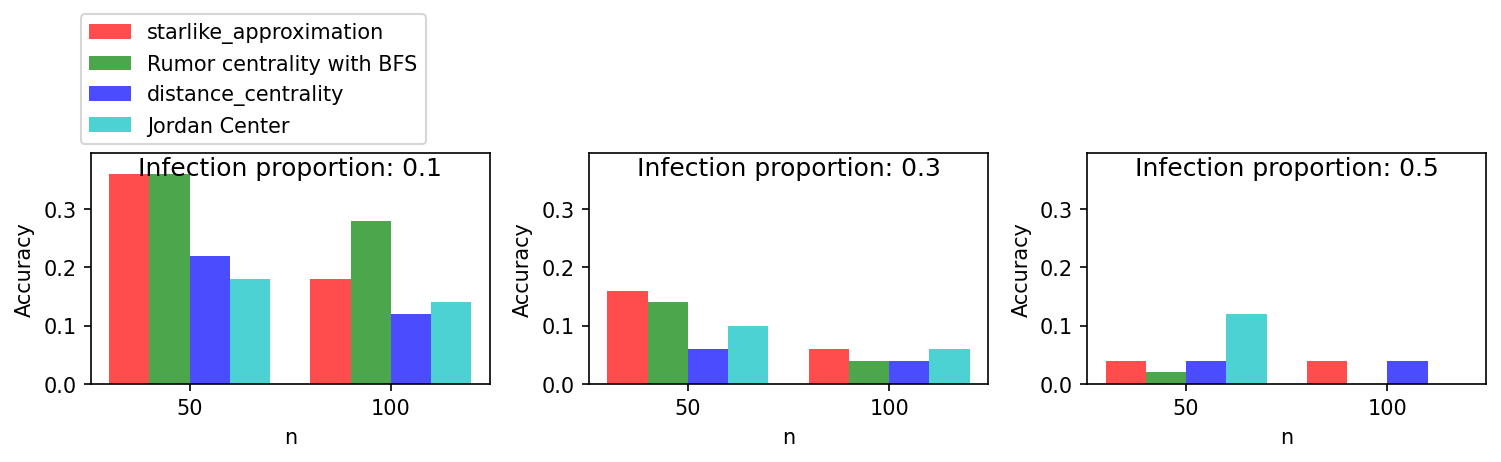

In [16]:
# Current code only considers \abs{p_list}=1
# Select the index of graph types in `graph_type_to_test` for plotting
graph_type_index = 0

color_list=['r','g','b','c']

graph_type_to_test=["random_tree", "ER", "WS_small_world"]
GRAPH_TYPE=graph_type_to_test[graph_type_index]
print("GRAPH_TYPE: ", GRAPH_TYPE)

centrality_type_to_test=['starlike_approximation', 'rumor_centrality', 'distance_centrality','jordan_center']


statistic_list=["zero_error_rate", "one_hop_error_rate"]
STATISTIC="zero_error_rate"



USE_SAME_YLIM=True
max_value=0
for centrality in centrality_type_to_test:
    max_value=max(max_value, np.nanmax(all_results[GRAPH_TYPE][centrality][STATISTIC][:,0,:]))

width=10
bar_pos_list=[i*width - (len(centrality_type_to_test)-1)/2*width for i in range(0,len(centrality_type_to_test))]
error_params=dict(elinewidth=4,ecolor='gray',capsize=5)

n_subfig=all_results[GRAPH_TYPE][centrality_type_to_test[0]][STATISTIC].shape[2]

fig, axs = plt.subplots((n_subfig)//3,3,figsize=(12, 1.7*n_subfig//2),dpi=150)

for j in range(0,n_subfig):
    axs_tmp = axs[j//3,j%3] if len(axs.shape)>=2 else axs[j%3]
    for idx in range(0,len(centrality_type_to_test)):
        axs_tmp.bar(np.array(n_list)+bar_pos_list[idx], all_results[GRAPH_TYPE][centrality_type_to_test[idx]][STATISTIC][:,0,j],alpha=0.7, width=width, color=color_list[idx],label=customize_legend(centrality_type_to_test[idx]))
  
    ADD_LEGEND=True
    if j==0 and ADD_LEGEND==True:
        axs_with_legend = axs[0,0] if len(axs.shape)>=2 else axs[0]
        axs_with_legend.legend(bbox_to_anchor=(0.1,1,0.74,0.6), borderaxespad=0)

    axs_tmp.set_title('Infection proportion: '+str(target_infected_ratio_list[j]),y=0.85)
    axs_tmp.set_xlabel('n')
    axs_tmp.xaxis.set_major_locator(plt.MultipleLocator(50))
    axs_tmp.set_ylabel('Accuracy')
    if USE_SAME_YLIM==True:
        axs_tmp.set_ylim(0, max_value * 1.1)
    else:
        axs_tmp.set_ylim()

# adjust the y-axis of the second row of subplots
for j in range(3,n_subfig):
    axs_tmp=axs[j//3,j%3] if len(axs.shape)>=2 else axs[j//3]
    axs_tmp.set_ylim(0, 0.2*1.1)

fig.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()



Plot the accuracy of the rumor detection methods against the infection proportion.

GRAPH_TYPE:  random_tree


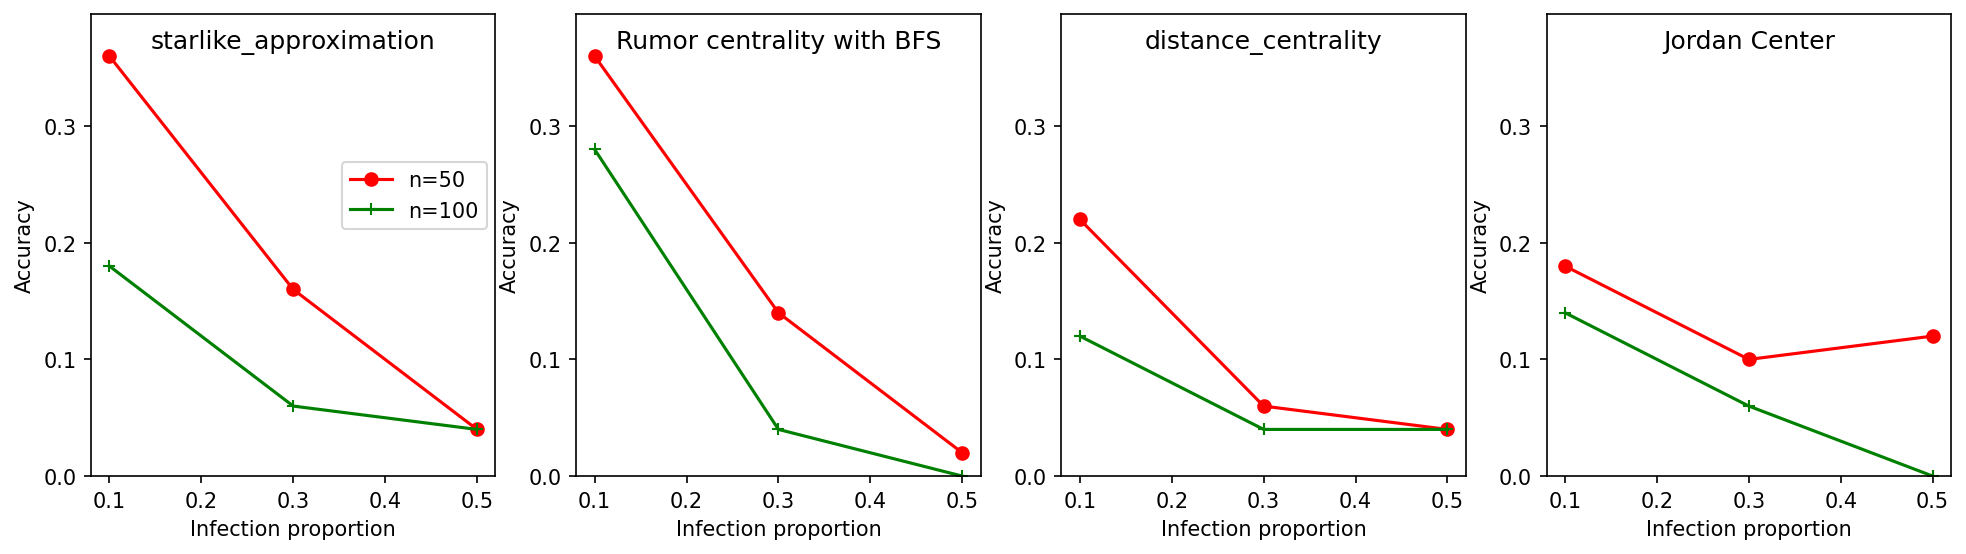

<Figure size 640x480 with 0 Axes>

In [17]:
# Select the index of graph types in `graph_type_to_test` for plotting
graph_type_index = 0

graph_type_to_test=["random_tree", "ER", "WS_small_world"]
GRAPH_TYPE=graph_type_to_test[graph_type_index]
print("GRAPH_TYPE: ", GRAPH_TYPE)

statistic_list=["zero_error_rate", "one_hop_error_rate"]

STATISTIC="zero_error_rate"

USE_SAME_YLIM=True
max_value=0
for centrality in centrality_type_to_test:
    max_value=max(max_value, np.nanmax(all_results[GRAPH_TYPE][centrality][STATISTIC][:,0,:]))

fmt_list=['r-','g-','b-','c-.','m-.','y-.']
marker_list=['o','+','^','o','+','^']
# point_fmt_list=['ro-','g+-','b^-', 'co-','m+-','y^-']


n_subfig=len(centrality_type_to_test)

fig, axs = plt.subplots(n_subfig//4,4,figsize=(16, 2*n_subfig//2),dpi=150)


fig=plt.figure()
for c in range(len(centrality_type_to_test)):
    for i in range(len(n_list)):
        axs[c%4].plot(target_infected_ratio_list,all_results[GRAPH_TYPE][centrality_type_to_test[c]][STATISTIC][i,0,:],fmt_list[i],marker=marker_list[i],label='n='+str(n_list[i]))
        # axs[c%4].plot(target_infected_ratio_list,all_results[GRAPH_TYPE][centrality_type_to_test[c]][STATISTIC][i,0,:],point_fmt_list[i])
    # axs[c%4].set_title(centrality_type_to_test[c]+ ': '+ STATISTIC+' - infection proportion in ' + GRAPH_TYPE+' graph')
    axs[c%4].set_title(customize_legend(centrality_type_to_test[c]),y=0.9)
    # plt.text(0.02,0.3,'')
    axs[c%4].set_xlabel('Infection proportion')
    axs[c%4].xaxis.set_major_locator(plt.MultipleLocator(0.1))
    # axs[c%4].set_ylabel(STATISTIC)
    axs[c%4].set_ylabel('Accuracy')
    axs[c%4].yaxis.set_major_locator(plt.MultipleLocator(0.1))
    if c==0:
        axs[c%4].legend(bbox_to_anchor=(0,0.48,0.98,0.2), borderaxespad=0)
    if USE_SAME_YLIM==True:
        axs[c%4].set_ylim(0, max_value * 1.1)
    else:
        axs[c%4].set_ylim()

fig.subplots_adjust(hspace=0.3)
plt.show()